In [3]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [12]:
import os
print(os.getcwd())

# 작업 디렉토리 변경
os.chdir('/gdrive/MyDrive/tess2')
print(os.getcwd())

/gdrive/MyDrive/tess2
/gdrive/MyDrive/tess2


In [13]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import os
import random
from sklearn.model_selection import KFold

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']

# 다시 임포트
from models import CNN , RNN
from Segdataset import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [6]:
print(CNN)

<class 'models.CNN'>


In [14]:
class Args:
    def __init__(self):
        self.data_root = '/gdrive/MyDrive/tess2/datasets/train'
        self.save_root = '/gdrive/MyDrive/tess2/checkpoints/RNN'
        self.epoch = 50
        self.lr = 3e-4
        self.batch_size = 32
        self.num_workers = 8
        self.random_seed = 1
        self.n_mfcc = 16
        self.n_splits = 5
        self.model_kind = 'rnn'

opt = Args()


In [15]:
def main():
    print("Training by RNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [16]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = RNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [17]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by RNN
Using device: cuda
Fold 1/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold 1 | Epoch 0 | Train Loss: 0.61357645796878 | Val Loss: 0.6019413407359805 | Val Accuracy: 0.5647321428571429
Fold 1 | Epoch 1 | Train Loss: 0.594334561909948 | Val Loss: 0.5913442969322205 | Val Accuracy: 0.4732142857142857
Fold 1 | Epoch 2 | Train Loss: 0.5601888884391103 | Val Loss: 0.5248795385871615 | Val Accuracy: 0.921875
Fold 1 | Epoch 3 | Train Loss: 0.5046272586498942 | Val Loss: 0.4926949824605669 | Val Accuracy: 0.9330357142857143
Fold 1 | Epoch 4 | Train Loss: 0.48590333653347834 | Val Loss: 0.47230542983327595 | Val Accuracy: 0.953125
Fold 1 | Epoch 5 | Train Loss: 0.46453175746968817 | Val Loss: 0.4963260889053345 | Val Accuracy: 0.8794642857142857
Fold 1 | Epoch 6 | Train Loss: 0.4624754233019693 | Val Loss: 0.45435125487191336 | Val Accuracy: 0.9709821428571429
Fold 1 | Epoch 7 | Train Loss: 0.448160174701895 | Val Loss: 0.4510774218610355 | Val Accuracy: 0.9776785714285714
Fold 1 | Epoch 8 | Train Loss: 0.4467268165733133 | Val Loss: 0.4483689250690596 | Val Accur

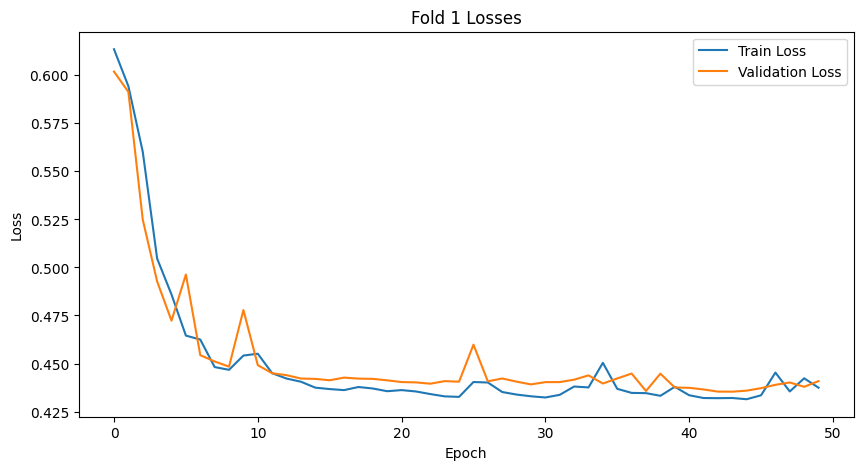

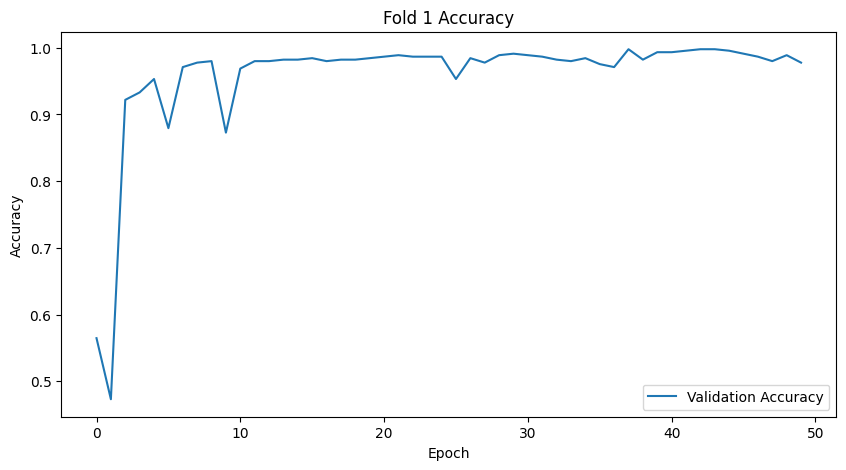

Fold 2/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 2 | Epoch 0 | Train Loss: 0.6208222753235272 | Val Loss: 0.5990318549530846 | Val Accuracy: 0.5959821428571429
Fold 2 | Epoch 1 | Train Loss: 0.6058630613344056 | Val Loss: 0.5959498754569462 | Val Accuracy: 0.40401785714285715
Fold 2 | Epoch 2 | Train Loss: 0.6030175409146717 | Val Loss: 0.594409914953368 | Val Accuracy: 0.40401785714285715
Fold 2 | Epoch 3 | Train Loss: 0.5706051641276905 | Val Loss: 0.5201816303389413 | Val Accuracy: 0.9263392857142857
Fold 2 | Epoch 4 | Train Loss: 0.5272097582263606 | Val Loss: 0.5010053196123668 | Val Accuracy: 0.8504464285714286
Fold 2 | Epoch 5 | Train Loss: 0.49564474501780104 | Val Loss: 0.4618275740316936 | Val Accuracy: 0.9508928571428571
Fold 2 | Epoch 6 | Train Loss: 0.48385212996176313 | Val Loss: 0.4534225080694471 | Val Accuracy: 0.9575892857142857
Fold 2 | Epoch 7 | Train Loss: 0.4724796451628208 | Val Loss: 0.4487251586147717 | Val Accuracy: 0.9620535714

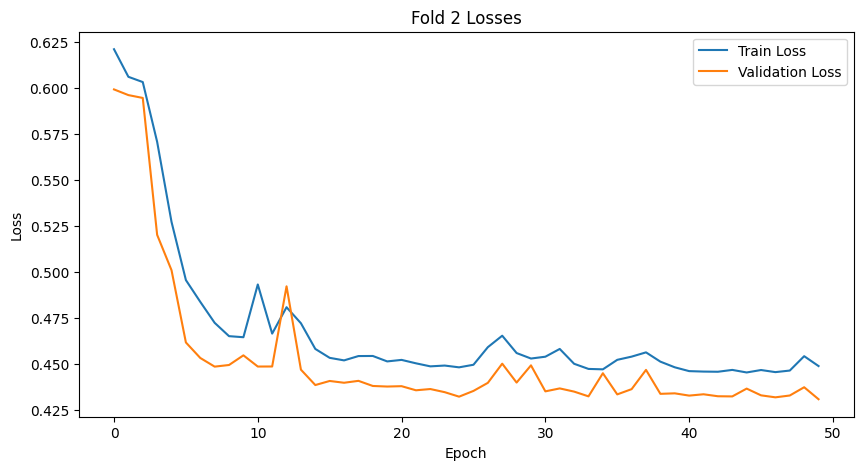

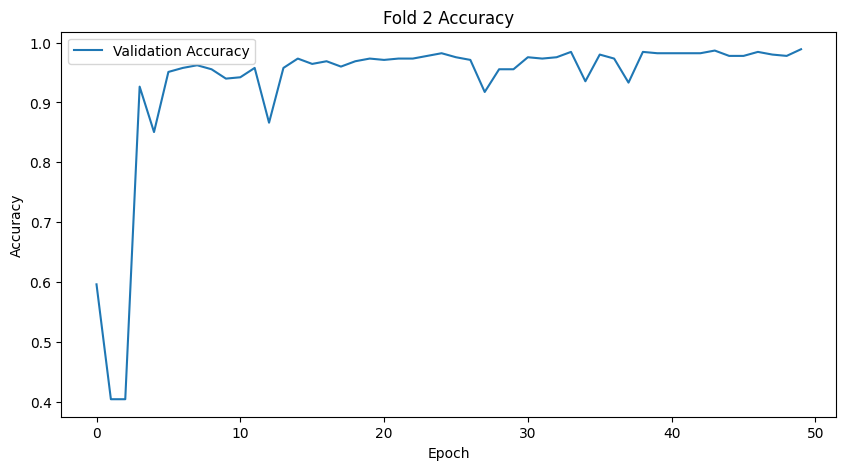

Fold 3/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 3 | Epoch 0 | Train Loss: 0.610999869448798 | Val Loss: 0.6059265988213676 | Val Accuracy: 0.5580357142857143
Fold 3 | Epoch 1 | Train Loss: 0.5922018044761249 | Val Loss: 0.5945984678609031 | Val Accuracy: 0.4419642857142857
Fold 3 | Epoch 2 | Train Loss: 0.5899711389626775 | Val Loss: 0.5935985999447959 | Val Accuracy: 0.4419642857142857
Fold 3 | Epoch 3 | Train Loss: 0.565912986440318 | Val Loss: 0.5297731416566032 | Val Accuracy: 0.8705357142857143
Fold 3 | Epoch 4 | Train Loss: 0.5272400895399707 | Val Loss: 0.5053161425249917 | Val Accuracy: 0.8839285714285714
Fold 3 | Epoch 5 | Train Loss: 0.49187504074403215 | Val Loss: 0.5003418113504138 | Val Accuracy: 0.8370535714285714
Fold 3 | Epoch 6 | Train Loss: 0.4732758030295372 | Val Loss: 0.4745351012263979 | Val Accuracy: 0.9464285714285714
Fold 3 | Epoch 7 | Train Loss: 0.46492327004671097 | Val Loss: 0.4756726718374661 | Val Accuracy: 0.9352678571428

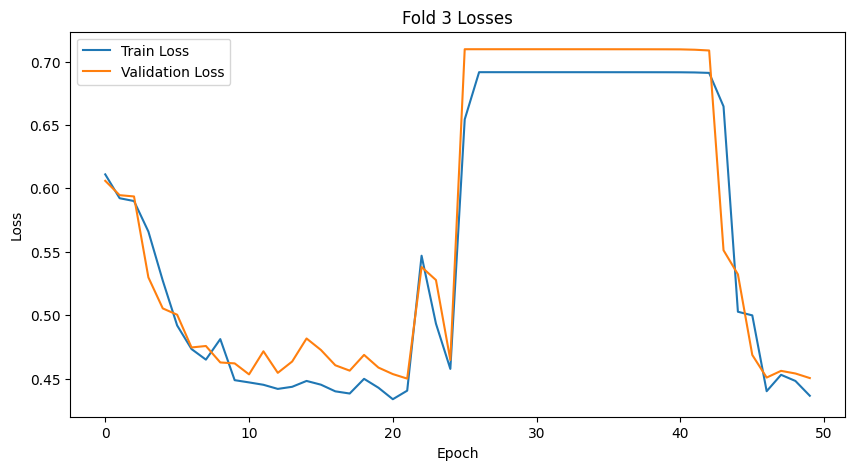

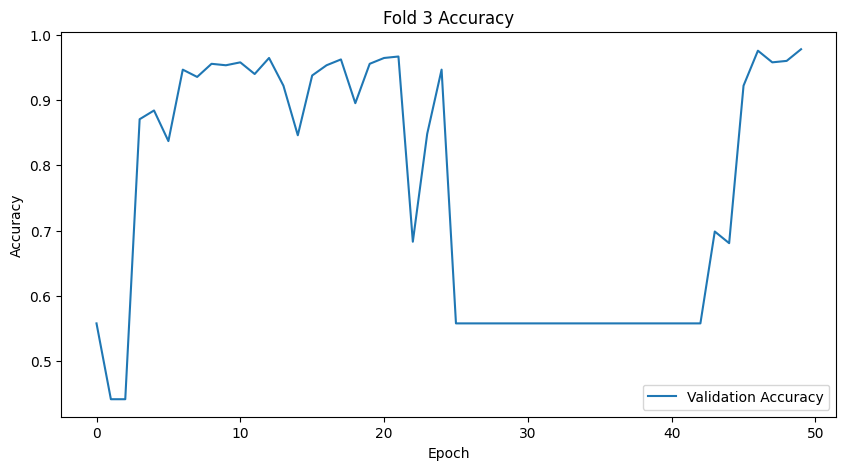

Fold 4/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 4 | Epoch 0 | Train Loss: 0.6212115830608776 | Val Loss: 0.5971799322537014 | Val Accuracy: 0.40848214285714285
Fold 4 | Epoch 1 | Train Loss: 0.6025307710681643 | Val Loss: 0.5956513860395977 | Val Accuracy: 0.40848214285714285
Fold 4 | Epoch 2 | Train Loss: 0.6005753321307046 | Val Loss: 0.5866123139858246 | Val Accuracy: 0.40848214285714285
Fold 4 | Epoch 3 | Train Loss: 0.5684171893766948 | Val Loss: 0.5437706304447991 | Val Accuracy: 0.8013392857142857
Fold 4 | Epoch 4 | Train Loss: 0.5197399407625198 | Val Loss: 0.48410829475947786 | Val Accuracy: 0.9375
Fold 4 | Epoch 5 | Train Loss: 0.48447168884532793 | Val Loss: 0.4635140278509685 | Val Accuracy: 0.9508928571428571
Fold 4 | Epoch 6 | Train Loss: 0.55604735655444 | Val Loss: 0.5164982335908073 | Val Accuracy: 0.7477678571428571
Fold 4 | Epoch 7 | Train Loss: 0.5084333536880357 | Val Loss: 0.45909776857921053 | Val Accuracy: 0.9375
Fold 4 | Epoch 8

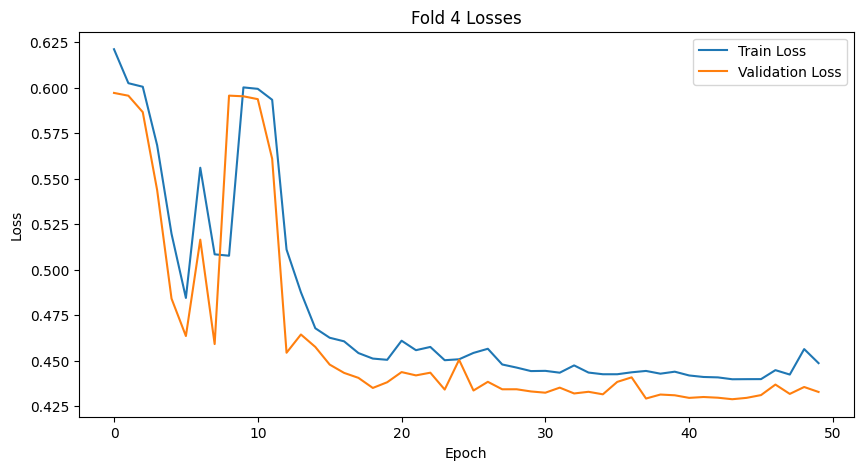

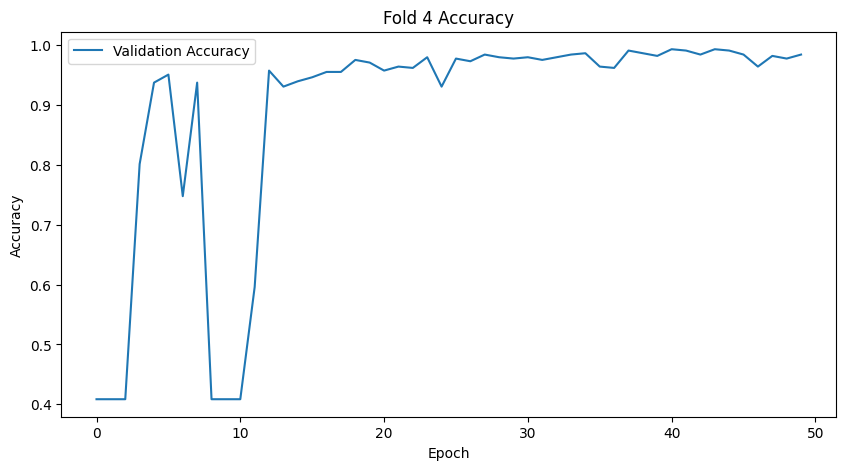

Fold 5/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 5 | Epoch 0 | Train Loss: 0.6059358763907637 | Val Loss: 0.6073217647416251 | Val Accuracy: 0.546875
Fold 5 | Epoch 1 | Train Loss: 0.5889957483325686 | Val Loss: 0.5959392743451255 | Val Accuracy: 0.453125
Fold 5 | Epoch 2 | Train Loss: 0.5853725075721741 | Val Loss: 0.58707338145801 | Val Accuracy: 0.5714285714285714
Fold 5 | Epoch 3 | Train Loss: 0.5427812385771956 | Val Loss: 0.5291904870952878 | Val Accuracy: 0.8928571428571429
Fold 5 | Epoch 4 | Train Loss: 0.5059409114931311 | Val Loss: 0.5093743737254824 | Val Accuracy: 0.9196428571428571
Fold 5 | Epoch 5 | Train Loss: 0.48349605766790255 | Val Loss: 0.5035593807697296 | Val Accuracy: 0.8459821428571429
Fold 5 | Epoch 6 | Train Loss: 0.46946875005960464 | Val Loss: 0.47201873681374956 | Val Accuracy: 0.9598214285714286
Fold 5 | Epoch 7 | Train Loss: 0.4576887238238539 | Val Loss: 0.47790998752628056 | Val Accuracy: 0.9486607142857143
Fold 5 | Epoch

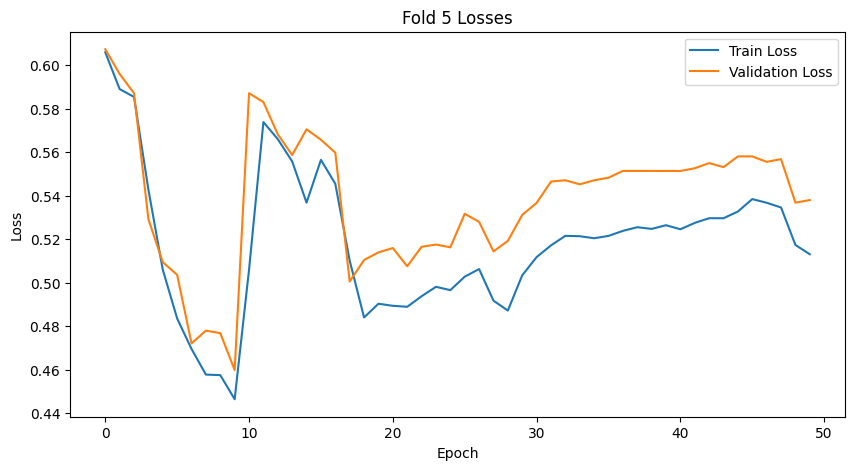

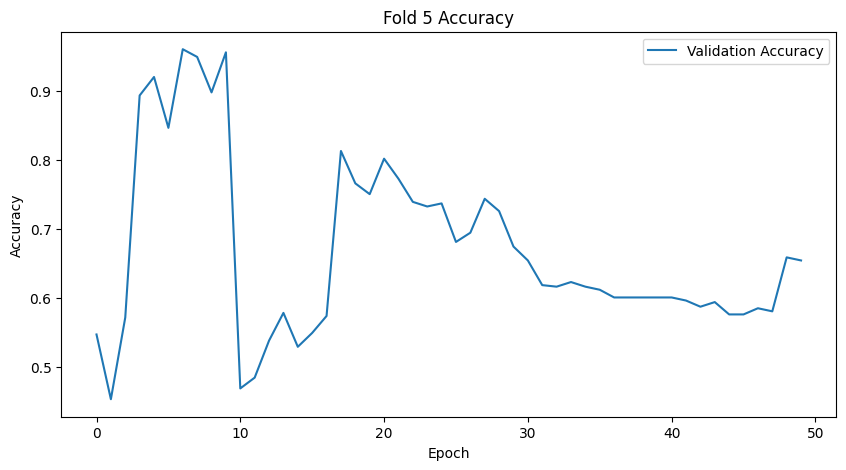

In [18]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)